#Spark

[Spark](https://spark.apache.org/) is a really awesome tool to easily do distributed computations in order to process large-scale data. To be honest, most people probably don't need spark for their own side projects - most of these data will fit in memory or work well in a traditional database like PostgreSQL. That being said, there is a good chance you might need Spark if you are doing data science type work for your job. A lot of companies have a tremendous amount of data and Spark is a great tool to help effectively process these large data.

In case you are not familiar with the map reduce structure, here is a very [brief introduction](http://hci.stanford.edu/courses/cs448g/a2/files/map_reduce_tutorial.pdf). Spark is based on this map reduce paradigm, but has made some nice improvements to the open source version Hadoop. A few of these improvements include the ability to cache data to memory, a simpler API supported in multiple languages (scala, python, and java I believe), and some really nice libraries - including a machine learning and SQL library. In my opinion, these additions really make Spark a powerful tool with a realtively easy learning curve.

My goal today is to show you how to get started with Spark and get introduced to Spark data frames.

#Installation

Fortunately, you don't need a cluster to get started with Spark. You can run it locally as well. This obviously doesn't provide the benefits of a cluster, but is great for learning.

Go ahead and install the latest verison of Spark (I would recommend pre-built with latest version of Hadoop) [here](https://spark.apache.org/downloads.html).

Once you download and unpack Spark, you can navigate to that directory. From there you can go to bin/pyspark to launch an interactive version of pyspark. This is really useful for experimentation, but let's see if we can't get Spark to work in your ipython notebook.

Follow the "Create PySpark Profile for IPython" [here](http://ramhiser.com/2015/02/01/configuring-ipython-notebook-support-for-pyspark/) **with the exception of changing PYSPARK_SUBMIT_ARGS to "--master local[2] pyspark-shell"** Adding the pyspark-shell to the end is now necessary.

You should now be able to run: ipython notebook --profile=pyspark. To test that it works make sure you can do the following:

In [11]:
sc

In [12]:
a=sc.parallelize([1,2,3,4])

In [13]:
a.collect()

[1, 2, 3, 4]

You should also now be able to go to http://localhost:4040/ and see the spark application UI. Hopefully you are now up and running with Spark in your IPython notebook! Also, as a quick side note, if you prefer using an IDE, check out this [post](https://gist.github.com/bigaidream/40fe0f8267a80e7c9cf8) on how to get autocompletion for Spark in PyCharm.

#[NY Data](https://data.ny.gov/)
New York provides a lot of open data that is easily accessible. A great resource to discovery some really interesting things about NY as well as cities in general. To showcase some of the Spark features, I will be taking a look at salary information for state authorities.

We are first going to use their API to grab up to 50,000 observations, convert the data to JSON and save to disk. We can then load the file into a Spark data frame.

In [14]:
import urllib2
import json
req = urllib2.Request('https://data.ny.gov/resource/unag-2p27.json?$limit=50000')
resp = urllib2.urlopen(req)
content = json.loads(resp.read())
with open("data/ny_salaries.json", "w") as f:
    json.dump(content, f)

#[Spark Data Frames](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

In [15]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.json("data/ny_salaries.json")

Lets take a look at the schema

In [16]:
df.printSchema()

root
 |-- actual_salary_paid: string (nullable = true)
 |-- authority_name: string (nullable = true)
 |-- base_annualized_salary: string (nullable = true)
 |-- department: string (nullable = true)
 |-- exempt_indicator: string (nullable = true)
 |-- extra_pay: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- fiscal_year_end_date: string (nullable = true)
 |-- group: string (nullable = true)
 |-- has_employees: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- middle_initial: string (nullable = true)
 |-- other_compensation: string (nullable = true)
 |-- overtime_paid: string (nullable = true)
 |-- paid_by_another_entity: string (nullable = true)
 |-- paid_by_state_or_local_government: string (nullable = true)
 |-- pay_type: string (nullable = true)
 |-- performance_bonus: string (nullable = true)
 |-- title: string (nullable = true)
 |-- total_compensation: string (nullable = true)



And now a specific column

In [17]:
df.select("total_compensation").show()

+------------------+
|total_compensation|
+------------------+
|          28725.55|
|          31973.09|
|          68654.00|
|          25826.95|
|          60114.08|
|          15257.43|
|          85000.00|
|          44454.64|
|          39474.83|
|           2240.00|
|          56267.98|
|           1817.60|
|           4530.33|
|          59186.44|
|          57664.04|
|           1333.50|
|          63339.92|
|          59782.21|
|          48451.11|
|          68632.35|
+------------------+



We can easily filter by column

In [18]:
df.filter(df["total_compensation"] > 100000).first()

Row(actual_salary_paid=u'133040.96', authority_name=u'Battery Park City Authority', base_annualized_salary=u'133041.00', department=u'Administration/BPCPC', exempt_indicator=u'Y', extra_pay=u'0.00', first_name=u'Tessa', fiscal_year_end_date=u'2011-10-31T00:00:00', group=u'Executive', has_employees=None, last_name=u'Huxley', middle_initial=None, other_compensation=u'750.00', overtime_paid=u'0.00', paid_by_another_entity=u'N', paid_by_state_or_local_government=None, pay_type=u'FT', performance_bonus=u'0.00', title=u'Executive Director', total_compensation=u'133790.96')

Now lets take a look at the highest paying departments on average. We first make sure to convert the column to float, and then use Spark's groupby and orderby operations to get the data we need.

In [19]:
from pyspark.sql.functions import desc
df_cast = df.withColumn("total_compensation_float", df.total_compensation.astype("float"))
top10 = (df_cast
         .groupBy("department")
         .mean("total_compensation_float")
         .orderBy(desc("AVG(total_compensation_float)"))
         .take(10))

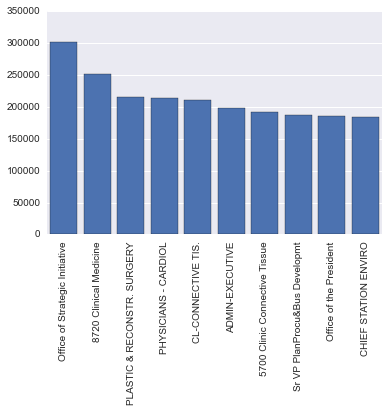

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

department = np.empty(10, dtype="S30")
salary = np.empty(10)
for i, row in enumerate(top10):
    department[i] = row[0]
    salary[i] = row[1]
sns.barplot(x=department, y=salary, x_order=department)
plt.xticks(rotation='vertical')
sns.despine()

Looks like a nice place to be is the Office of Strategic Initative...but I wonder how many people are in that department in our data? Let's utilize the SQL query method on our data frame
#To SQL

In [21]:
df_cast.registerTempTable("df_cast")
sqlContext.sql("select count(*) from df_cast where department = 'Office of Strategic Initiative'").collect()

[Row(c0=1)]

Looks like there is only one lucky person :). We could also convert our Spark data frame to a pandas data frame and do the same calculation. Nice.
#To Pandas

In [22]:
df_pandas = df_cast.toPandas()
df_pandas.department.value_counts()['Office of Strategic Initiative']

1

#Summary Statistics / Functions

In [23]:
df_cast.describe('total_compensation_float').show()

+-------+------------------------+
|summary|total_compensation_float|
+-------+------------------------+
|  count|                   49997|
|   mean|       63374.58037148814|
| stddev|       35402.40384989916|
|    min|                     0.0|
|    max|               735124.75|
+-------+------------------------+



Wow - that is a high max. Lets take a look at the departments by max salary. Excuse the pandas oneliner - would just be the same Spark code as used above to get the average

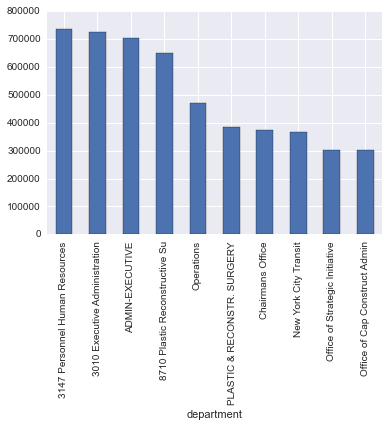

In [24]:
df_pandas.groupby('department')["total_compensation_float"].max().order(ascending=False)[:10].plot(kind="bar")

There are definitely a few outliers here. Let's just quickly see the distribution for the highest department

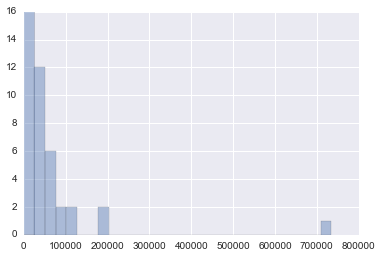

In [25]:
salaries = sqlContext.sql("""
        select total_compensation_float 
        from df_cast
        where department = '3147 Personnel Human Resources' """).collect()
sns.distplot(salaries, kde=False)
sns.despine()

Wow - someone is making a killing in this department. Or maybe an error?

Spark also has some nifty functions. For example, we can quickly make cross tabulations. Check out the API for a lot more functions available.

In [26]:
from pyspark.sql import DataFrameStatFunctions as sf

In [27]:
sf(df_cast).crosstab("paid_by_another_entity", "fiscal_year_end_date").collect()

[Row(paid_by_another_entity_fiscal_year_end_date=u'Y', 2011-03-31T00:00:00=7, 2011-12-31T00:00:00=0, 2012-03-31T00:00:00=5, 2012-12-31T00:00:00=0, 2013-03-31T00:00:00=5, 2012-10-31T00:00:00=0, 2013-12-31T00:00:00=0, 2013-10-31T00:00:00=0, 2011-06-30T00:00:00=0, 2011-10-31T00:00:00=0, 2012-06-30T00:00:00=0, 2013-06-30T00:00:00=0),
 Row(paid_by_another_entity_fiscal_year_end_date=u'N', 2011-03-31T00:00:00=2376, 2011-12-31T00:00:00=35169, 2012-03-31T00:00:00=2348, 2012-12-31T00:00:00=3548, 2013-03-31T00:00:00=2272, 2012-10-31T00:00:00=183, 2013-12-31T00:00:00=3602, 2013-10-31T00:00:00=208, 2011-06-30T00:00:00=24, 2011-10-31T00:00:00=202, 2012-06-30T00:00:00=24, 2013-06-30T00:00:00=24),
 Row(paid_by_another_entity_fiscal_year_end_date=u'null', 2011-03-31T00:00:00=1, 2011-12-31T00:00:00=0, 2012-03-31T00:00:00=1, 2012-12-31T00:00:00=0, 2013-03-31T00:00:00=1, 2012-10-31T00:00:00=0, 2013-12-31T00:00:00=0, 2013-10-31T00:00:00=0, 2011-06-30T00:00:00=0, 2011-10-31T00:00:00=0, 2012-06-30T00:00:00=

#Learn More
* [Databricks Spark SQL blog](https://databricks.com/blog/category/sparksql)
* [Spark SQL API](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

Well I hope this helped you get started with Spark locally and showcased some of the features of data frames. As always, please feel free to email me with questions / comments.